In [20]:
import re, os, operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from os import listdir
from tabulate import tabulate


%matplotlib inline

In [4]:
import collections
'''Vocabulary class, nearly identical to that used in a4'''
class Vocabulary(object):

  UNK_TOKEN = "<unk>"

  def __init__(self, tokens, size=None):
    self.unigram_counts = collections.Counter(tokens)
    # leave space for "<unk>"
    top_counts = self.unigram_counts.most_common(None if size is None else (size - 1))
    vocab = ([self.UNK_TOKEN] +
             [w for w,c in top_counts])

    # Assign an id to each word, by frequency
    self.id_to_word = dict(enumerate(vocab))
    self.word_to_id = {v:k for k,v in self.id_to_word.iteritems()}
    self.size = len(self.id_to_word)
    if size is not None:
        assert(self.size <= size)

    # For convenience
    self.wordset = set(self.word_to_id.iterkeys())

    # Store special IDs
    self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

  def words_to_ids(self, words):
    return [self.word_to_id.get(w, self.UNK_ID) for w in words]

  def ids_to_words(self, ids):
    return [self.id_to_word[i] for i in ids]

  def ordered_words(self):
    """Return a list of words, ordered by id."""
    return self.ids_to_words(range(self.size))


In [5]:
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word):
    word = word.lower()
    return canonicalize_digits(word) # try to canonicalize numbers

def replace_all(text, dic):
    for i, j in dic.iteritems():
        text = text.replace(i, j)
    return text

def canonicalize_words(words):
    current = []
    rep_dict = {'\n':' '
                ,'\xc2':' '
                ,'\xa0':' '
                ,'\xc2':' '
                ,'\xc3':' '
                ,'\xa9':' '
                ,'\xef':' '
                ,'\xbb':' '
                ,'\xbf':' '
                ,'\xa6':' '
                ,'\xb9':' '
                ,'\xa3':' '
                ,'\xbd':' '
                ,'\xb4':' '
                ,'\xcb':' '
                ,'\x9a':' '
                ,'\x86':' '
                ,'\xcf':' '
                ,'\x84':' '
                ,'\xce':' '
                ,'\x87':' '
                ,'\xe2':' '
                ,'\x80':' '
                ,'\x94':' '
               }
    for word in replace_all(words, rep_dict).split(' '):   
        if word:
            if word[-1] in ('.', ',', '?', ';', '!'):
                punk = word[-1]
                current.append(punk)
                word = word[0:-1]

            word = canonicalize_word(word)
            current.append(word)
    return current

In [61]:
def document_statistics(doc_path):
    
    # Returns No. sentences, No. words
    
    with open(doc_path, "r") as f:
        file_contents = f.read()
        
        return file_contents.count('.'), len(file_contents.split())
    
def author_struct():
    vocab = {'original':0
            ,'processed':0}
    author_dict = {'sentences':0
                  ,'words':0
                  ,'words_to_sents':0.0
                  ,'vocab_size':vocab}
    return author_dict

   
def database_statistics(raw_dir, clean_dir):
    authors = {}
    for author in [ name for name in os.listdir(raw_dir) if os.path.isdir(os.path.join(raw_dir, name)) ]:
        auth_name = author.replace('_',' ').title()
        all_tokens = []
        authors[auth_name] = author_struct()
        for file_name in listdir(raw_dir + '/' + author):
            doc_path = raw_dir + '/' + author + '/' + file_name
            doc_stats = document_statistics(doc_path)
            authors[auth_name]['sentences'] += doc_stats[0]
            authors[auth_name]['words'] += doc_stats[1]
            with open(doc_path, "r") as f:
                current = canonicalize_words(f.read())
                all_tokens += current
        
        vocab = Vocabulary(all_tokens)
        authors[auth_name]['words_to_sents'] = authors[auth_name]['words']*1./authors[auth_name]['sentences']
        authors[auth_name]['vocab_size']['original'] = vocab.size
        
    for author in [ name for name in os.listdir(clean_dir) if os.path.isdir(os.path.join(clean_dir, name)) ]:
        auth_name = author.replace('_',' ').title()
        all_tokens = []
        for file_name in listdir(clean_dir + '/' + author):
            doc_path = clean_dir + '/' + author + '/' + file_name
            with open(doc_path, "r") as f:
                current = canonicalize_words(f.read())
                all_tokens += current
        
        vocab = Vocabulary(all_tokens)
        authors[auth_name]['vocab_size']['processed'] = vocab.size
        
    return authors

def incremental_vocab_size(clean_dir, federalist_authors, other_authors):
    vocab_tokens = []
    all_tokens = []
    vocab_size = {}
    for author in federalist_authors:
        for file_name in listdir(clean_dir + '/' + author):
            doc_path = clean_dir + '/' + author + '/' + file_name
            with open(doc_path, "r") as f:
                current = canonicalize_words(f.read())
                all_tokens += current
        
    vocab = Vocabulary(all_tokens)
    vocab_tokens += all_tokens
    print 'Vocabulary size of the Federalist Papers: {}'.format(vocab.size)
    vocab_size['Federalist'] = vocab.size
    vocab = None
    while len(other_authors) > 0:
        vocab_size_temp = {}
        for author in other_authors:
            all_tokens = []
            for file_name in listdir(clean_dir + '/' + author):
                doc_path = clean_dir + '/' + author + '/' + file_name
                with open(doc_path, "r") as f:
                    current = canonicalize_words(f.read())
                    all_tokens += current
        
            vocab = Vocabulary(all_tokens + vocab_tokens)
            vocab_size_temp[author] = vocab.size
            vocab = None
            print 'Vocabulary size increased to {0} by adding {1}'.format(vocab_size_temp[author],
                                                                          author.replace('_',' ').title())
        author = max(vocab_size_temp.iteritems(), key=operator.itemgetter(1))[0]
        print 'Selecting {} as the next author'.format(author.replace('_',' ').title())
        vocab_size[author.replace('_',' ').title()] = vocab_size_temp[author]
        other_authors.remove(author)
        all_tokens = vocab_tokens
        for file_name in listdir(clean_dir + '/' + author):
            doc_path = clean_dir + '/' + author + '/' + file_name
            with open(doc_path, "r") as f:
                current = canonicalize_words(f.read())
                all_tokens += current
                
        vocab_tokens += all_tokens
    df = pd.DataFrame.from_dict(vocab_size, orient = 'index').rename(columns = {0:'Vocab Size'}).sort_values('Vocab Size')
    df.index.name = 'Authors'
    return df

def pretty_print_df(df):
    print tabulate(df, headers='keys', tablefmt='psql')
    
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

In [47]:
raw = 'raw_data'
train = 'train_data'
authors = database_statistics(raw,train)
df = pd.DataFrame.from_dict(authors).transpose()
df = df[['words', 'sentences', 'words_to_sents', 'vocab_size']]
df.index.name = 'Author'
df

,words,sentences,words_to_sents,vocab_size
Author,,,,
Alexander Hamilton,1512817,62612,24.1618,"{u'original': 26437, u'processed': 20693}"
Benjamin Franklin,70199,2523,27.8236,"{u'original': 7688, u'processed': 7029}"
George Washington,19903,674,29.5297,"{u'original': 3329, u'processed': 3075}"
James Madison,1583467,100068,15.8239,"{u'original': 27005, u'processed': 19113}"
James Monroe,45597,1449,31.4679,"{u'original': 4147, u'processed': 3764}"
John Adams,168191,6604,25.468,"{u'original': 12568, u'processed': 1622}"
John Jay,8374,199,42.0804,"{u'original': 1754, u'processed': 1566}"
Thomas Jefferson,2888245,136333,21.1852,"{u'original': 37796, u'processed': 33649}"
Thomas Paine,364912,14224,25.6547,"{u'original': 18251, u'processed': 11725}"


+--------------------+---------+-------------+------------------+-----------------------------------------+
| Author             |   words |   sentences |   words_to_sents | vocab_size                              |
|--------------------+---------+-------------+------------------+-----------------------------------------|
| Alexander Hamilton | 1512817 |       62612 |          24.1618 | {'original': 26437, 'processed': 20693} |
| Benjamin Franklin  |   70199 |        2523 |          27.8236 | {'original': 7688, 'processed': 7029}   |
| George Washington  |   19903 |         674 |          29.5297 | {'original': 3329, 'processed': 3075}   |
| James Madison      | 1583467 |      100068 |          15.8239 | {'original': 27005, 'processed': 19113} |
| James Monroe       |   45597 |        1449 |          31.4679 | {'original': 4147, 'processed': 3764}   |
| John Adams         |  168191 |        6604 |          25.468  | {'original': 12568, 'processed': 1622}  |
| John Jay           |    83

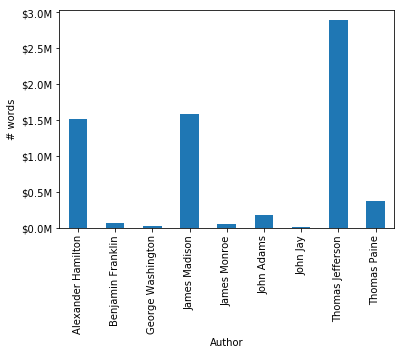

In [15]:
pretty_print_df(df)
#print df.to_latex()

formatter = FuncFormatter(millions)
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
words = df['words'].plot(kind='bar')
words.set_ylabel('# words')

plt.show()

In [16]:
df['words']

Author
Alexander Hamilton    1512817
Benjamin Franklin       70199
George Washington       19903
James Madison         1583467
James Monroe            45597
John Adams             168191
John Jay                 8374
Thomas Jefferson      2888245
Thomas Paine           364912
Name: words, dtype: object

In [62]:
clean_dir = 'train_data'
federalist_authors = ['john_jay', 'james_madison', 'alexander_hamilton']
other_authors = ['john_adams', 'thomas_paine','thomas_jefferson','james_monroe', 'george_washington', 'benjamin_franklin']
author_contrib = incremental_vocab_size(clean_dir, federalist_authors, other_authors)

Vocabulary size of the Federalist Papers: 27936
Vocabulary size increased to 27951 by adding John Adams
Vocabulary size increased to 30705 by adding Thomas Paine
Vocabulary size increased to 45143 by adding Thomas Jefferson
Vocabulary size increased to 28072 by adding James Monroe
Vocabulary size increased to 28011 by adding George Washington
Vocabulary size increased to 29710 by adding Benjamin Franklin
Selecting Thomas Jefferson as the next author
Vocabulary size increased to 45152 by adding John Adams
Vocabulary size increased to 47105 by adding Thomas Paine
Vocabulary size increased to 45228 by adding James Monroe
Vocabulary size increased to 45191 by adding George Washington
Vocabulary size increased to 46428 by adding Benjamin Franklin
Selecting Thomas Paine as the next author
Vocabulary size increased to 47113 by adding John Adams
Vocabulary size increased to 47187 by adding James Monroe
Vocabulary size increased to 47151 by adding George Washington
Vocabulary size increased to 

In [64]:
pretty_print_df(author_contrib)

+-------------------+--------------+
| Authors           |   Vocab Size |
|-------------------+--------------|
| Federalist        |        27936 |
| Thomas Jefferson  |        45143 |
| Thomas Paine      |        47105 |
| Benjamin Franklin |        48338 |
| James Monroe      |        48419 |
| George Washington |        48464 |
| John Adams        |        48471 |
+-------------------+--------------+


In [81]:
[(author, author_contrib.get_value(author,'Vocab Size')) for author in author_contrib.index]

[('Federalist', 27936),
 ('Thomas Jefferson', 45143),
 ('Thomas Paine', 47105),
 ('Benjamin Franklin', 48338),
 ('James Monroe', 48419),
 ('George Washington', 48464),
 ('John Adams', 48471)]

In [68]:
author_contrib.index

Index([u'Federalist', u'Thomas Jefferson', u'Thomas Paine',
       u'Benjamin Franklin', u'James Monroe', u'George Washington',
       u'John Adams'],
      dtype='object', name=u'Authors')

In [78]:
print author_contrib.get_value(u'Federalist','Vocab Size')

27936
